In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from keras.src.trainers.data_adapters.data_adapter_utils import class_weight_to_sample_weights
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import panel as pn 
import plotly.express as px
import hvplot.pandas 

In [2]:
df = pd.read_csv("/Users/nguyentoan/Documents/Bank_Customer_Churn/Data/Bank_data.csv")

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
X = df.drop(['customer_id','churn'], axis = 1)
y = df['churn']

In [6]:
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [13]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
categorical_features = ["country", "gender"]
numerical_features = [
    "credit_score", "age", "tenure",
    "balance", "products_number",
    "credit_card", "active_member",
    "estimated_salary"
]

preprocessor  = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

## RandomForest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)

y_prob_rf = rf_pipeline.predict_proba(X_test)[:,1]
print("RandomForest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

RandomForest ROC-AUC: 0.8575815729846046


In [21]:
y_pred_rf = (y_prob_rf >= 0.5).astype(int)

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



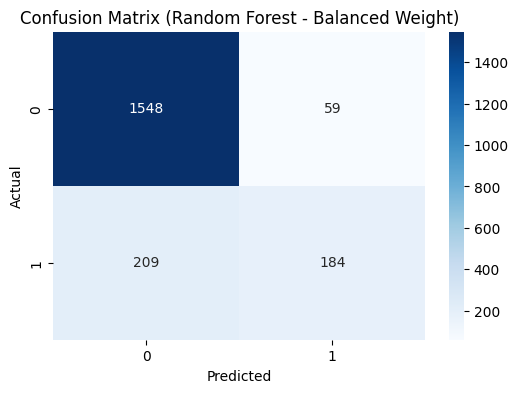

In [22]:
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True,
            fmt='d',
            cmap='Blues')
plt.title("Confusion Matrix (Random Forest - Balanced Weight)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Detailed Performance Analysis
- Class 1 Recall Issue (0.47): The model is "missing" too many Class 1 instances. Out of every 10 actual Class 1 cases, the model successfully identifies fewer than 5.

- Data Imbalance: Despite using Balanced Weight, the model still shows a heavy bias toward Class 0 (which accounts for ~80% of the data). Class 0 achieves a Recall of 0.96, meaning it captures almost all Class 0 instances but does so at the expense of Class 1 performance.

- Class 1 Precision (0.76): This metric is relatively solid. It indicates that when the model actually predicts Class 1, there is a high probability (76%) that it is correct. However, the model is overall too "conservative" or "hesitant" in making Class 1 predictions.

## XGBoost

In [26]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:,1]

XGBoost ROC-AUC: 0.8666774338097795
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1607
           1       0.74      0.51      0.61       393

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000



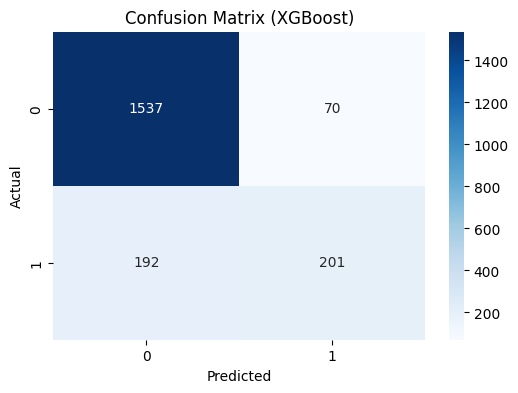

In [27]:
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print(classification_report(y_test, y_pred_xgb))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb),
            annot=True,
            fmt='d',
            cmap='Blues')
plt.title("Confusion Matrix (XGBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Overall Performance Summary
- ROC-AUC (0.866): The model demonstrates a strong ability to distinguish between the two classes (0 and 1).

- Accuracy (0.87): While the overall accuracy is high, it is heavily influenced by the majority class (Class 0) due to the significant data imbalance.
### Class-Specific Analysis (Focus on Class 1)
- Recall Improvement (0.51): There is a slight improvement in the model's ability to identify Class 1 instances compared to the previous Random Forest model (from 0.47 to 0.51).

- Precision (0.74): When the model predicts an instance as Class 1, there is a 74% probability that the prediction is correct.

- F1-Score (0.61): The slight increase from 0.58 (Random Forest) to 0.61 (XGBoost) indicates that this model is handling the minority class more effectively.

## lightgbm 

In [ ]:
from lightgbm import LGBMClassifier

lgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        random_state=42,
        scale_pos_weight=4.1 # Imposing weight on minority groups.
    ))
])
lgb_pipeline.fit(X_train, y_train)

y_prob_lgb = lgb_pipeline.predict_proba(X_test)[:,1]
print("LightGBM ROC-AUC:", roc_auc_score(y_test, y_prob_lgb))

[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205500 -> initscore=-1.352267
[LightGBM] [Info] Start training from score -1.352267
LightGBM ROC-AUC: 0.857317936318682


/Users/nguyentoan/Documents/Bank_Customer_Churn/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM ROC-AUC: 0.857317936318682
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1607
           1       0.44      0.78      0.56       393

    accuracy                           0.76      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.84      0.76      0.78      2000



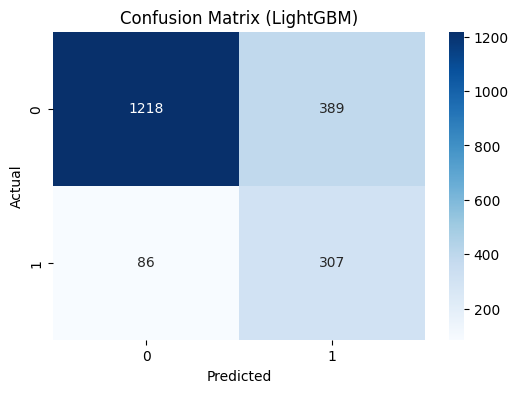

In [37]:
# y_pred_lgb = (y_prob_lgb >= 0.5).astype(int)
y_pred_new = (y_prob_lgb >= 0.3).astype(int)
print("LightGBM ROC-AUC:", roc_auc_score(y_test, y_prob_lgb))
print(classification_report(y_test, y_pred_new))

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_new),
            annot=True,
            fmt='d',
            cmap='Blues')
plt.title("Confusion Matrix (LightGBM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The model successfully addressed the class imbalance issue, achieving a significant boost in Class 1 Recall (0.78). While this resulted in a lower Precision (0.44) and overall Accuracy (0.76), the model is now much more effective at capturing minority class instances, which is critical for the project's objectives.

In [38]:
print("Random Forest AUC :", roc_auc_score(y_test, y_prob_rf))
print("XGBoost AUC       :", roc_auc_score(y_test, y_prob_xgb))
print("LightGBM AUC      :", roc_auc_score(y_test, y_prob_lgb))

Random Forest AUC : 0.8575815729846046
XGBoost AUC       : 0.8666774338097795
LightGBM AUC      : 0.857317936318682


### Comparative Performance Analysis (Churn Class '1')
1. Comparative Results
- Baseline Models (RF/XGBoost): Recall ≈ 0.47 – 0.51 (Missed nearly half of the potential churners).

- Optimized LightGBM (Current): Recall = 0.78 (A significant leap in detection capability).
2. Business Impact
- The Gain: We are now successfully identifying 78%  of customers at risk of leaving. This represents a 27% to 31% improvement over previous iterations. This high sensitivity allows the bank to proactively intervene with retention programs, such as personalized offers or loyalty rewards, before the customer officially terminates the relationship.

- The Trade-off: To achieve this high recall, Precision shifted to 0.44. This implies that while we flag more potential churners, we also include a portion of loyal customers in our outreach (False Positives). However, in the banking industry, the cost of a "False Positive" (e.g., sending an unnecessary promotional email to a happy customer) is negligible compared to the high "Customer Acquisition Cost" (CAC) required to replace a lost client.

### Final Verdict
- The Optimized LightGBM model, configured with class-weight balancing, delivers the most actionable business intelligence. By prioritizing Recall (78%) over global accuracy, the model shifts the bank's strategy from a reactive stance to a proactive defense, ensuring that the vast majority of at-risk revenue is flagged for retention efforts